In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
#uploaded = files.upload()

Mounted at /content/drive


In [ ]:
import os
files = os.listdir('/content/drive/MyDrive/Fibre_shaking')
files = files [0:5]
print(files)


['output-20231101-123827.flac', 'output-20231101-123726.flac', 'output-20231101-123928.flac', 'output-20231101-123625.flac', 'output-20231101-124028.flac']


In [ ]:
import librosa
import numpy as np
paths = []
for file in files[1:]:
  paths.append(f"/content/drive/MyDrive/Fibre_shaking/{file}")
#"/content/output-6.flac"
def get_timestamps(y, sr):
  segment_length = int(0.1 * sr)
  overlap_length = int(0.05 * sr)
  timestamps_raw = [i / sr for i in range(0, len(y[0]) - segment_length + 1, segment_length - overlap_length)]
  return timestamps_raw

audio_dict = {}

for path in paths:
  print(path)
  y, sr = librosa.load(path, sr=44100, mono=False)
  #y = librosa.util.normalize(y, axis=1)
  audio_dict[path] = {
      "audio": y,
      "sample_rate": sr,
      "timestamps": get_timestamps(y, sr)
  }

print(audio_dict[paths[1]]['timestamps'][:100])

/content/drive/MyDrive/Fibre_shaking/output-20231101-123726.flac
/content/drive/MyDrive/Fibre_shaking/output-20231101-123928.flac
/content/drive/MyDrive/Fibre_shaking/output-20231101-123625.flac
/content/drive/MyDrive/Fibre_shaking/output-20231101-124028.flac
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3.0, 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5, 3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4.0, 4.05, 4.1, 4.15, 4.2, 4.25, 4.3, 4.35, 4.4, 4.45, 4.5, 4.55, 4.6, 4.65, 4.7, 4.75, 4.8, 4.85, 4.9, 4.95]


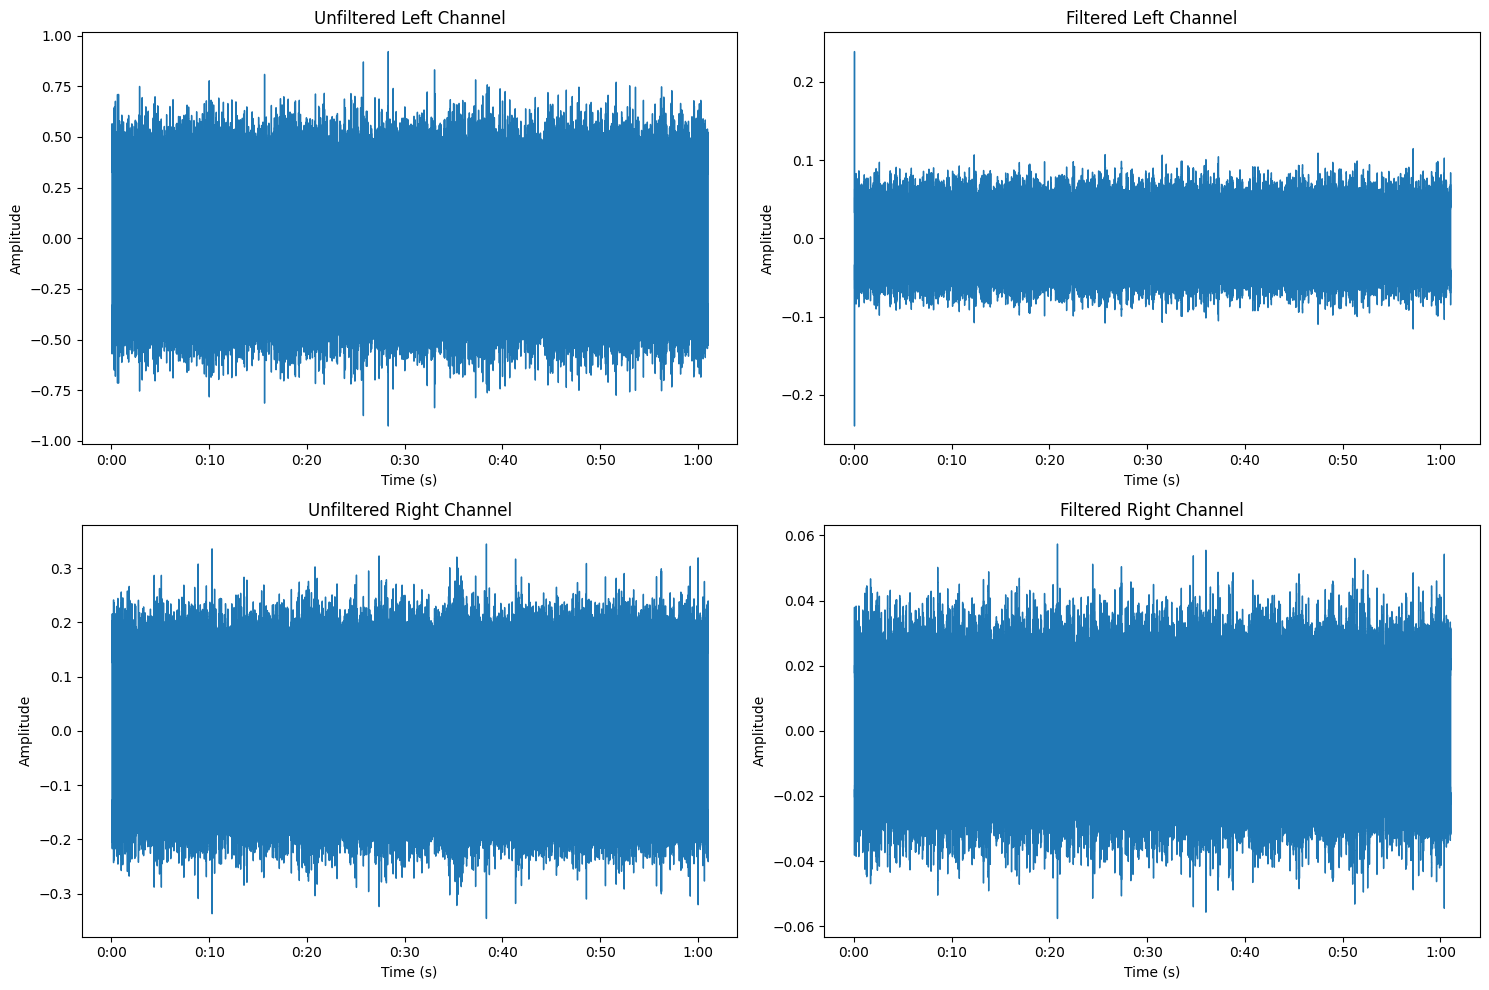

In [ ]:
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import librosa.display

# Design a low-pass Butterworth filter
def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Example usage with audio 2 - right channel
raw_data_left = audio_dict[paths[2]]['audio'][0]
raw_data_right = audio_dict[paths[2]]['audio'][1]
sr = audio_dict[paths[2]]['sample_rate']
cutoff_frequency = 300  # Hz
sampling_rate = sr  # Assuming 20 kHz sampling
filtered_data_left = low_pass_filter(raw_data_left, cutoff_frequency, sampling_rate)
filtered_data_right = low_pass_filter(raw_data_right, cutoff_frequency, sampling_rate)

# Display the waveforms for comparison
plt.figure(figsize=(15, 10))

# Left channel comparison
plt.subplot(2, 2, 1)
librosa.display.waveshow(raw_data_left, sr=sr)
plt.title("Unfiltered Left Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 2)
librosa.display.waveshow(filtered_data_left, sr=sr)
plt.title("Filtered Left Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Right channel comparison
plt.subplot(2, 2, 3)
librosa.display.waveshow(raw_data_right, sr=sr)
plt.title("Unfiltered Right Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 4)
librosa.display.waveshow(filtered_data_right, sr=sr)
plt.title("Filtered Right Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def dict_gen(y, sr=44100, frame_duration=0.1, hop_frame=0.05):
    audio_dataset = {}
    raw_data_left = y["audio"][0]
    raw_data_right = y["audio"][1]
    cutoff_frequency = 300  # Hz
    sampling_rate = sr  # Assuming 20 kHz sampling

    filtered_data_left = low_pass_filter(raw_data_left, cutoff_frequency, sampling_rate)
    filtered_data_right = low_pass_filter(raw_data_right, cutoff_frequency, sampling_rate)

    # Calculate frame length and hop length in samples
    frame_length = int(sr * frame_duration)
    overlap_length = int(sr * hop_frame)

    # Convert the audio signal into frames (2D array: frame_length x number_of_frames)
    frames_left = librosa.util.frame(filtered_data_left, frame_length=frame_length, hop_length=overlap_length)
    frames_right = librosa.util.frame(filtered_data_right, frame_length=frame_length, hop_length=overlap_length)

    # Transpose the frames to iterate over each frame (each column represents a frame)
    frames_T_right = frames_right.T
    frames_T_left = frames_left.T

    # Compute features for each frame
    energy_right = np.sum(frames_T_right**2, axis=1)  # Energy for each frame
    energy_left = np.sum(frames_T_left**2, axis=1)  # Energy for each frame
    rms_energy_left = np.sqrt(np.mean(frames_T_left**2, axis=1))  # RMS energy for each frame
    rms_energy_right = np.sqrt(np.mean(frames_T_right**2, axis=1))  # RMS energy for each frame
    max_energy_left = frames_T_left[np.arange(frames_T_left.shape[0]), np.argmax(np.abs(frames_T_left), axis=1)]
    max_energy_right = frames_T_right[np.arange(frames_T_right.shape[0]), np.argmax(np.abs(frames_T_right), axis=1)]


    mfcc_left = librosa.feature.mfcc(y=filtered_data_left, sr=sr, n_mfcc=15,  n_fft=frame_length, hop_length=overlap_length)
    mfcc_right = librosa.feature.mfcc(y=filtered_data_right, sr=sr, n_mfcc=15,  n_fft=frame_length, hop_length=overlap_length)
    mfcc_transpose_left = mfcc_left.T
    mfcc_transpose_right = mfcc_right.T
    num_frames = min(mfcc_left.shape[1], energy_left.shape[0])

    # Compute Zero Crossing Rate (ZCR) for each frame
    """zcr = []
    for frame in frames_T:  # Iterate over transposed frames
        frame_zcr = librosa.feature.zero_crossing_rate(frame)  # ZCR for a single frame
        zcr.append(frame_zcr[0][0])  # Extract the ZCR value"""

    # Populate audio dataset dictionary
    #audio_dataset["average_energy-left"] = energy_left.tolist()
    #audio_dataset["rms_energy-left"] = rms_energy_left.tolist()
    #audio_dataset["max_energy-left"] = max_energy_left.tolist()


    for i in range(1, 16):
        audio_dataset["mfcc_" + str(i) + "_left"] = mfcc_transpose_left[:num_frames, i-1].tolist()


    #audio_dataset["average_energy-right"] = energy_right.tolist()
    #audio_dataset["rms_energy-right"] = rms_energy_right.tolist()
   # audio_dataset["max_energy-right"] = max_energy_right.tolist()
    for i in range(1, 16):
        audio_dataset["mfcc_" + str(i) + "_right"] = mfcc_transpose_right[:num_frames, i-1].tolist()

    return audio_dataset


In [ ]:
#generate a feature matrix for each audio
feature_vector = {}
for file, data in audio_dict.items():

  timestamps = data["timestamps"]
  feature_vector[file] = dict_gen(data)
  feature_vector[file]["timestamps"] = timestamps



In [ ]:
import pandas as pd

# Initialize a dictionary to store DataFrames
dataframes = {}

# Convert each file's features into a DataFrame
for file, features in feature_vector.items():
    # Ensure timestamps are in float format
    timestamps = features["timestamps"]

    # Add the timestamps directly to the DataFrame
    df = pd.DataFrame({key: pd.Series(value) for key, value in features.items()})

    # Store the DataFrame in the dictionary
    dataframes[file] = df

    # Save each DataFrame to a CSV file (optional)
    df.to_csv(f"{file}_features.csv", index=False)

# Example: Accessing one of the DataFrames
example_file = list(dataframes.keys())[0]
print(f"Features for {example_file}:")
print(dataframes[example_file].head())


Features for /content/drive/MyDrive/Fibre_shaking/output-20231101-123726.flac:
   mfcc_1_left  mfcc_2_left  mfcc_3_left  mfcc_4_left  mfcc_5_left  \
0  -267.946678   131.221576    24.799844    27.689846    17.857074   
1  -602.800065   126.114109   114.959072    98.035133    77.523799   
2  -599.002404   131.279902   119.560880   101.851708    80.519799   
3  -603.083015   125.847527   115.050425    98.593108    78.502725   
4  -599.974944   129.936596   118.306395   100.723009    79.528080   

   mfcc_6_left  mfcc_7_left  mfcc_8_left  mfcc_9_left  mfcc_10_left  ...  \
0    16.273165    12.217771    10.365716     7.908330      6.477969  ...   
1    55.909948    35.561209    18.359441     5.454544     -2.819968  ...   
2    58.231799    37.482699    20.193393     7.456322     -0.529652  ...   
3    57.116931    36.707192    19.139270     5.632320     -3.345962  ...   
4    57.364679    36.713528    19.494046     6.808515     -1.129108  ...   

   mfcc_7_right  mfcc_8_right  mfcc_9_right

In [ ]:
example_file = list(dataframes.keys())[1]
df = dataframes[example_file]
print(f"dataframe for audio shape: {df.shape}")
right = df.filter(regex='right')
left = df.filter(regex='left')
timestamps = df["timestamps"]
print(right.head())
print(left.head())

print(f"right shape: {right.shape}")
print(f"left shape: {left.shape}")
values_right = right.values
values_left = left.values

print(values_right.shape)
print(values_left.shape)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(values_right)
StandardScaler(copy=True, with_mean=True, with_std=True)
samples_scaled = scaler.transform(values_right)

model = KMeans(n_clusters=2)
labels_right = model.fit_predict(values_right)

print(labels_right)
print(model.inertia_)




datapoint shape: (1199, 31)
   mfcc_1_right  mfcc_2_right  mfcc_3_right  mfcc_4_right  mfcc_5_right  \
0   -468.269628     77.305586     64.648703     48.274768     32.850350   
1   -483.001424     60.158869     56.980834     51.950284     45.438865   
2   -479.236791     65.360314     61.822681     56.219001     48.958039   
3   -480.533173     63.626944     60.375552     55.205202     48.465864   
4   -480.491163     63.659816     60.331573     55.042048     48.153568   

   mfcc_6_right  mfcc_7_right  mfcc_8_right  mfcc_9_right  mfcc_10_right  \
0     21.518383     14.926809     11.671183      9.652160       7.403054   
1     37.914898     29.898551     21.913418     14.439815       7.874734   
2     40.555910     31.587507     22.633846     14.231002       6.825955   
3     40.603900     32.123749     23.545542     15.362785       8.004098   
4     40.127891     31.486253     22.765240     14.472785       7.048508   

   mfcc_11_right  mfcc_12_right  mfcc_13_right  mfcc_14_right  m

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
kmeans = KMeans(n_clusters=2)

pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(values_right)
labels = pipeline.predict(values_right)
print(labels)
print(kmeans.inertia_)


[0 0 0 ... 0 0 0]
12190.233736082439


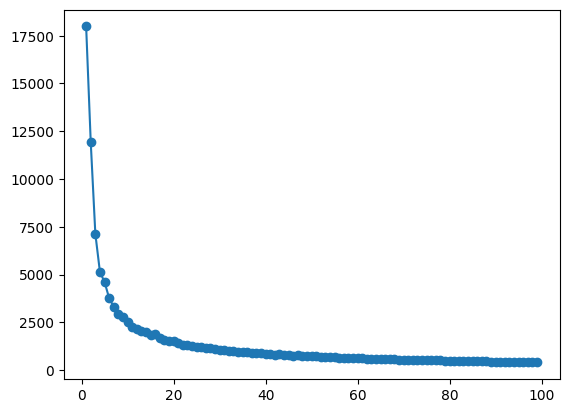

In [ ]:
clusters = range(1, 100)
inertia_list=[]
for k in clusters:
  scaler = StandardScaler()
  kmeans = KMeans(n_clusters=k)
  pipeline = make_pipeline(scaler, kmeans)
  pipeline.fit(values_right)
  inertia_list.append(kmeans.inertia_)

plt.plot(clusters, inertia_list, "-o")


In [ ]:
#Principal Component Analysis

from sklearn.decomposition import PCA
scaler = StandardScaler()
data_standardized = scaler.fit_transform(values_right)
model = PCA()
model.fit(data_standardized)
model.transform(data_standardized)
print(model.explained_variance_ratio_)
print(model.singular_values_)



[6.18124709e-01 3.10704252e-01 6.82964880e-02 2.62884819e-03
 2.45155750e-04 5.46140081e-07 2.67650061e-10 5.31373734e-14
 1.70406250e-16 4.69483694e-17 2.20792135e-17 6.78677520e-19
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[1.05437057e+02 7.47530332e+01 3.50472872e+01 6.87603336e+00
 2.09979193e+00 9.91076654e-02 2.19401147e-03 3.09140043e-05
 1.75064457e-06 9.18894131e-07 6.30154469e-07 1.10480836e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [ ]:
pca = PCA(n_components=3)  # Retaining 4 PCs (~95% variance)
data_reduced = pca.fit_transform(data_standardized)
print(data_reduced)

[[  2.59266703 -10.52303468   9.39097658]
 [  0.49401975  -5.15861494   1.74135897]
 [ -2.12845762  -4.90022839   0.26840197]
 ...
 [  0.06510123  -1.80780404  -0.18879747]
 [ -0.05475612  -1.01696351   0.97586694]
 [ -0.19119803   1.82207982  -1.08465769]]


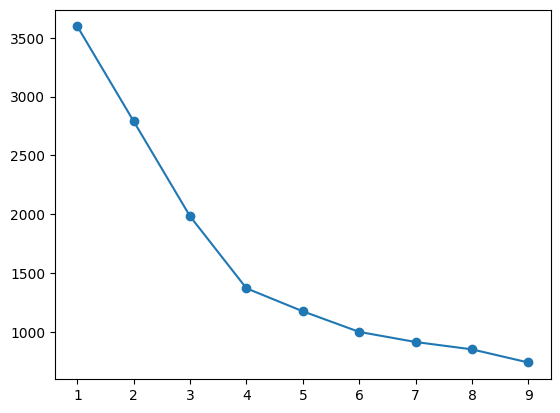

In [ ]:
clusters = range(1, 10)
inertia_list=[]
for k in clusters:
  scaler = StandardScaler()
  kmeans = KMeans(n_clusters=k)
  pipeline = make_pipeline(scaler, kmeans)
  pipeline.fit(data_reduced)
  inertia_list.append(kmeans.inertia_)

plt.plot(clusters, inertia_list, "-o")

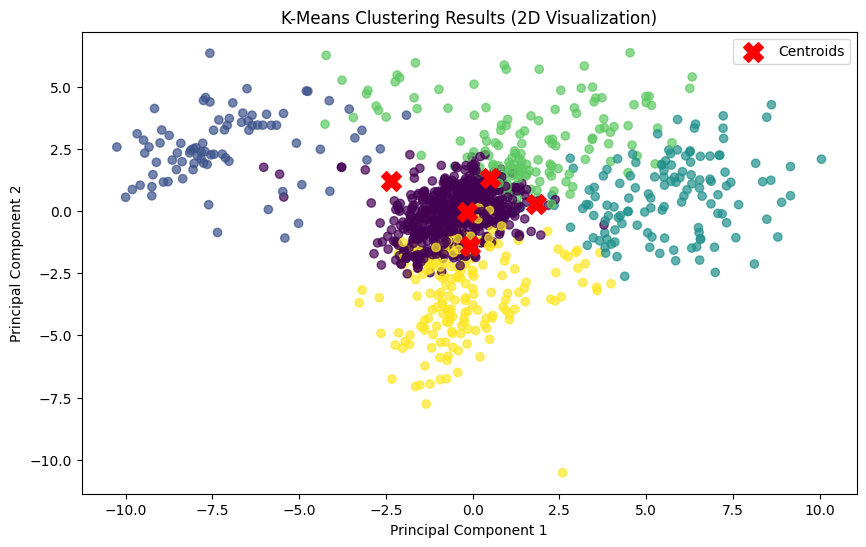

In [ ]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=5)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(data_reduced)

# Predict cluster labels using the pipeline
cluster_labels = pipeline.predict(data_reduced)

# If data_reduced has 2 dimensions, plot it
plt.figure(figsize=(10, 6))

# Scatter plot, coloring points by their cluster labels
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

# Mark cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids')

plt.title("K-Means Clustering Results (2D Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

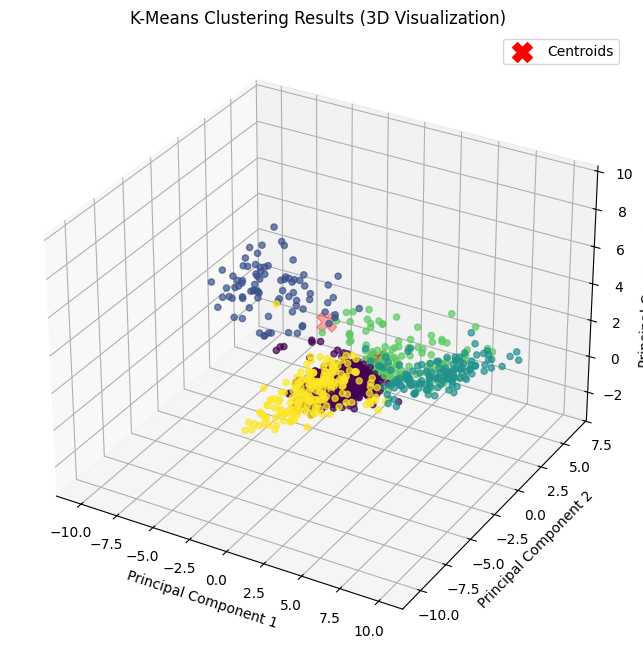

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot, coloring points by their cluster labels
scatter = ax.scatter(data_reduced[:, 0], data_reduced[:, 1], data_reduced[:, 2], c=cluster_labels, cmap='viridis', alpha=0.7)

# Mark cluster centers
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=200, marker='X', label='Centroids')

ax.set_title("K-Means Clustering Results (3D Visualization)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.legend()
plt.show()


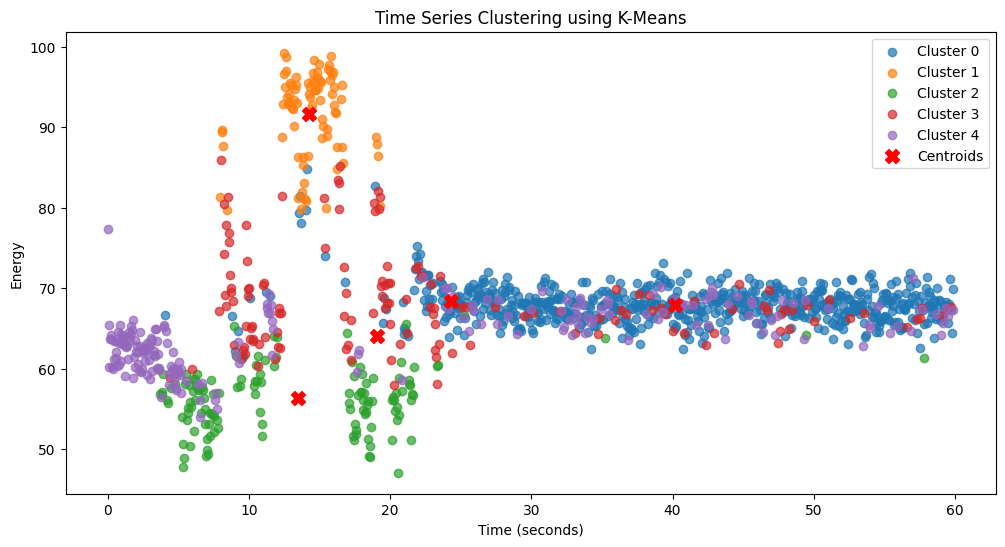

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict cluster labels
cluster_labels = pipeline.predict(data_reduced)
energy = values_right[:, 1]

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique cluster labels
unique_clusters = np.unique(cluster_labels)

# Plot energy values over time, colored by clusters
for cluster in unique_clusters:
    cluster_mask = cluster_labels == cluster
    ax.scatter(timestamps[cluster_mask], energy[cluster_mask],
            label=f'Cluster {cluster}', alpha=0.7, marker='o')

# Mark centroids on the plot
centroid_times = [np.mean(timestamps[cluster_labels == cluster]) for cluster in unique_clusters]
centroid_energies = [np.mean(energy[cluster_labels == cluster]) for cluster in unique_clusters]
ax.scatter(centroid_times, centroid_energies, c='red', marker='X', s=100, label='Centroids')

# Plot formatting
ax.set_title("Time Series Clustering using K-Means")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Energy")
ax.legend()
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest

# Assuming 'features' is your feature matrix
isolation_forest = IsolationForest(contamination=0.07, random_state=42)
anomaly_scores = isolation_forest.fit_predict(data_reduced)

# Anomaly labels: -1 indicates an anomaly, 1 indicates a normal point
print(f"Anomaly scores from fit_predict(): {anomaly_scores}")

anomaly_scores = isolation_forest.decision_function(data_reduced)
print(f"Anomaly scores from decision_function(): {anomaly_scores} and length: {len(anomaly_scores)}")


threshold = -0.02
anomalies = anomaly_scores < threshold
num_anomalies = np.sum(anomalies)

print(f"Number of anomalies detected: {num_anomalies}")



Anomaly scores from fit_predict(): [-1 -1  1 ...  1  1  1]
Anomaly scores from decision_function(): [-0.17506942 -0.01392843  0.04592908 ...  0.18371654  0.1508331
  0.17086561] and length: 1199
Number of anomalies detected: 47


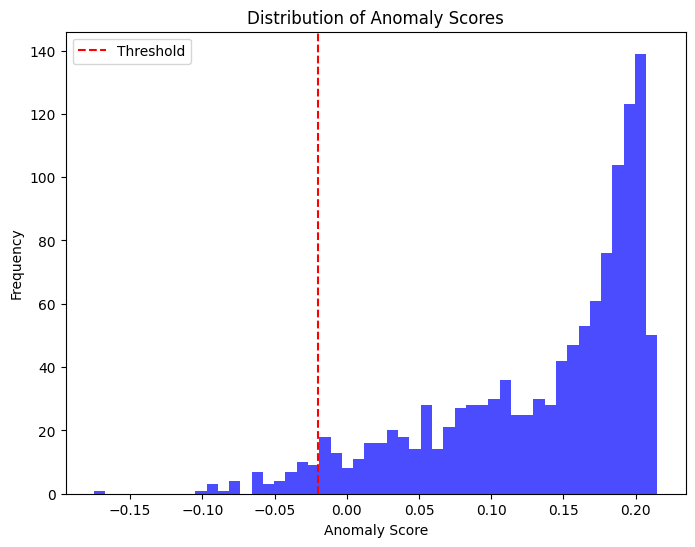

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'anomaly_scores' contains the anomaly scores from Isolation Forest
plt.figure(figsize=(8, 6))
plt.hist(anomaly_scores, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")

threshold = -0.02  # Example threshold value
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()

plt.show()

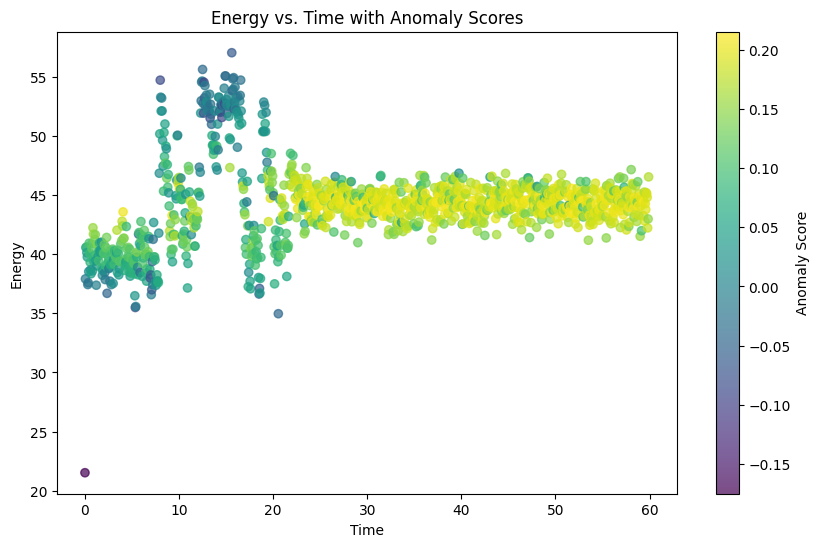

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(timestamps, energy, c=anomaly_scores, cmap='viridis', alpha=0.7)
plt.colorbar(label='Anomaly Score')
plt.title("Energy vs. Time with Anomaly Scores")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.show()

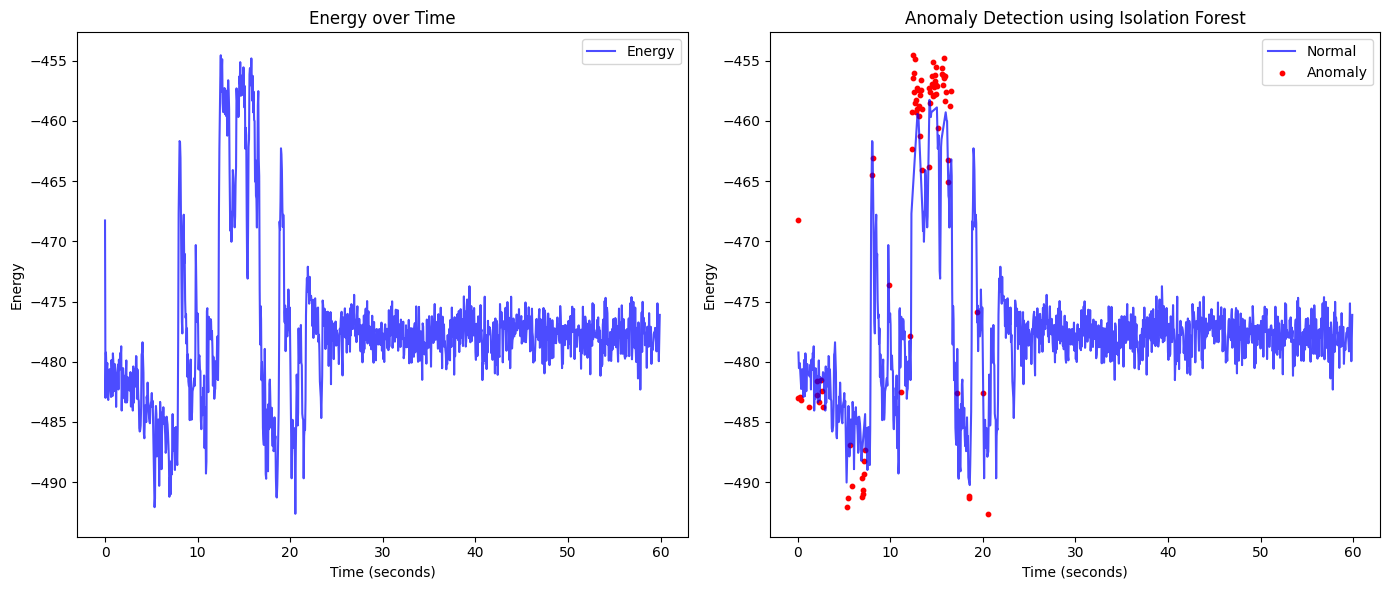

In [ ]:

# Scatter plot for 2D features (Energy vs. First MFCC)
energy = values_right[:, 0]  # Assuming energy values are stored here

import matplotlib.pyplot as plt

# Assuming energy, timestamps, anomaly_scores are already defined

normal_points = energy[anomaly_scores == 1]
anomalies = energy[anomaly_scores == -1]
normal_times = timestamps[anomaly_scores == 1]
anomaly_times = timestamps[anomaly_scores == -1]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot energy against time in the first subplot
axes[0].plot(timestamps, energy, color='blue', label='Energy', alpha=0.7)
#axes[0].set_xlim(10, 15)
axes[0].set_title("Energy over Time")
axes[0].set_xlabel("Time (seconds)")
axes[0].set_ylabel("Energy")
axes[0].legend()

# Plot anomalies in the second subplot using Isolation Forest
axes[1].plot(normal_times, normal_points, color='blue', label='Normal', alpha=0.7)
axes[1].scatter(anomaly_times, anomalies, color='red', label='Anomaly', marker='o', s=10)
#axes[1].set_xlim(10, 15)
axes[1].set_title("Anomaly Detection using Isolation Forest")
axes[1].set_xlabel("Time (seconds)")
axes[1].set_ylabel("Energy")
axes[1].legend()

# Adjust spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Assume `data` is your dataset (NumPy array)
data = values_right
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Convert to PyTorch tensors
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=False)


In [ ]:
# Initialize model, loss function, and optimizer
input_dim = data_tensor.shape[1]
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 100
autoencoder.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in dataloader:
        inputs = batch[0]

        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")


Epoch [1/100], Loss: 1.0018
Epoch [2/100], Loss: 0.9254
Epoch [3/100], Loss: 0.5566
Epoch [4/100], Loss: 0.3016
Epoch [5/100], Loss: 0.1313
Epoch [6/100], Loss: 0.1268
Epoch [7/100], Loss: 0.1214
Epoch [8/100], Loss: 0.1942
Epoch [9/100], Loss: 0.0948
Epoch [10/100], Loss: 0.0854
Epoch [11/100], Loss: 0.0912
Epoch [12/100], Loss: 0.1489
Epoch [13/100], Loss: 0.1693
Epoch [14/100], Loss: 0.0907
Epoch [15/100], Loss: 0.1542
Epoch [16/100], Loss: 0.0954
Epoch [17/100], Loss: 0.1322
Epoch [18/100], Loss: 0.0648
Epoch [19/100], Loss: 0.1036
Epoch [20/100], Loss: 0.0626
Epoch [21/100], Loss: 0.1063
Epoch [22/100], Loss: 0.0563
Epoch [23/100], Loss: 0.0886
Epoch [24/100], Loss: 0.0588
Epoch [25/100], Loss: 0.0999
Epoch [26/100], Loss: 0.0576
Epoch [27/100], Loss: 0.0922
Epoch [28/100], Loss: 0.0717
Epoch [29/100], Loss: 0.0951
Epoch [30/100], Loss: 0.0575
Epoch [31/100], Loss: 0.0798
Epoch [32/100], Loss: 0.0570
Epoch [33/100], Loss: 0.0829
Epoch [34/100], Loss: 0.0598
Epoch [35/100], Loss: 0

In [ ]:
# Switch to evaluation mode
autoencoder.eval()

# Reconstruct the data
with torch.no_grad():
    reconstructed = autoencoder(data_tensor)

# Compute reconstruction error
reconstruction_error = torch.mean((data_tensor - reconstructed) ** 2, axis=1).numpy()

# Determine the anomaly threshold
threshold = np.percentile(reconstruction_error, 95)  # Top 5% errors

# Identify anomalies
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")


Number of anomalies detected: 60


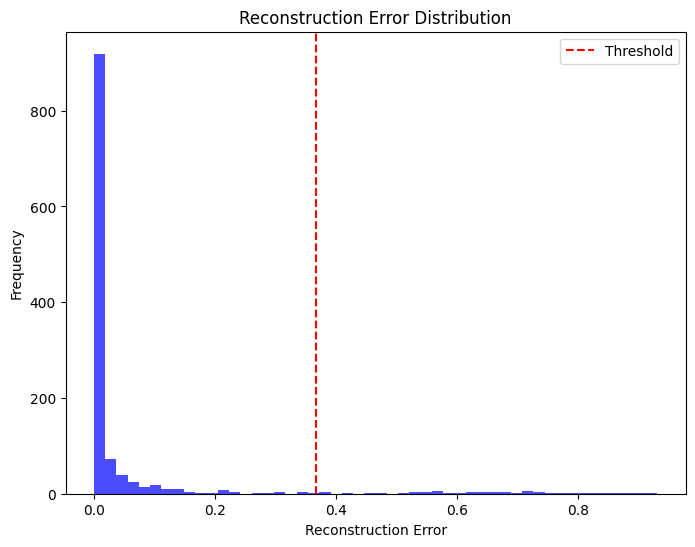

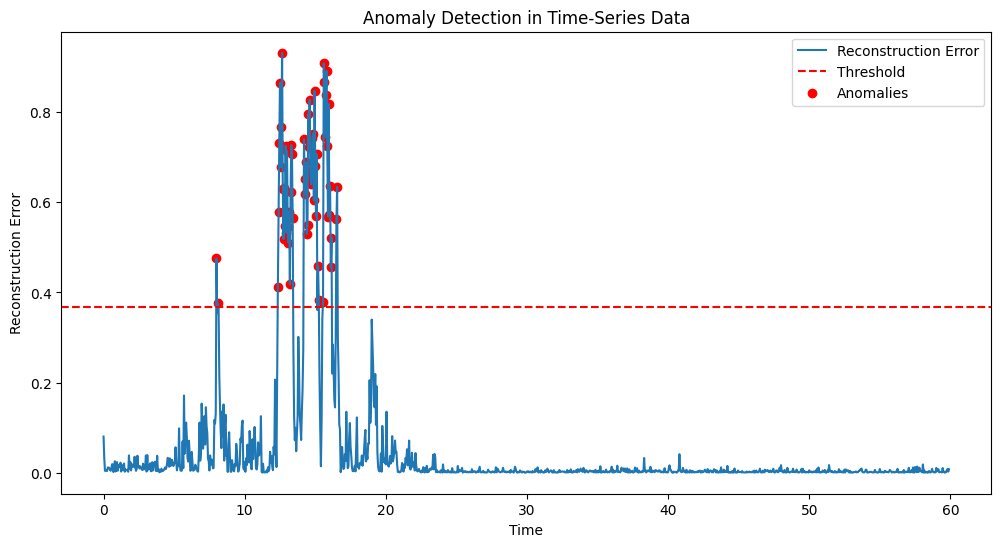

In [ ]:
import matplotlib.pyplot as plt

# Plot the reconstruction error distribution
plt.figure(figsize=(8, 6))
plt.hist(reconstruction_error, bins=50, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Time-series visualization (if applicable)
 # Replace with your actual timestamps
plt.figure(figsize=(12, 6))
plt.plot(timestamps, reconstruction_error, label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
plt.scatter(timestamps[anomalies], reconstruction_error[anomalies], color='red', label="Anomalies")
plt.title("Anomaly Detection in Time-Series Data")
plt.xlabel("Time")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


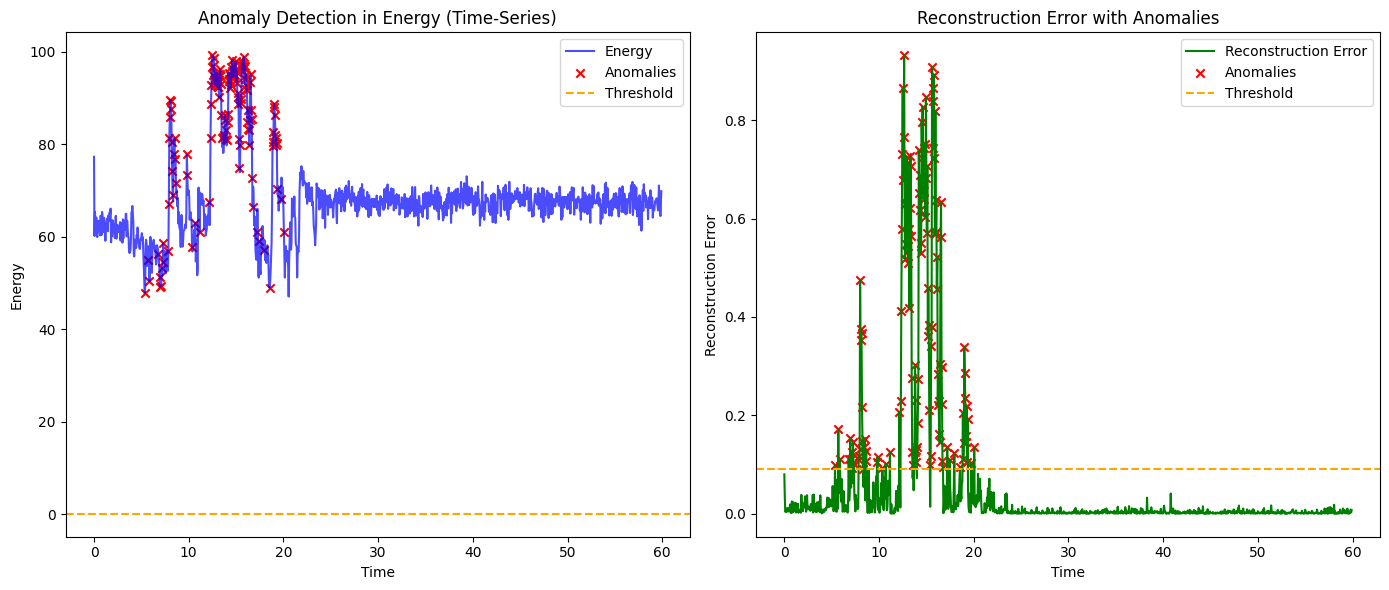

In [ ]:
# Compute reconstruction errors
autoencoder.eval()
with torch.no_grad():
    reconstructed = autoencoder(data_tensor)

# Calculate reconstruction error
reconstruction_error = torch.mean((data_tensor - reconstructed) ** 2, axis=1).numpy()

# Set a threshold (95th percentile)
threshold = np.percentile(reconstruction_error, 89)

# Identify normal and anomalous points
anomalies = reconstruction_error > threshold
normal_points = reconstruction_error <= threshold

# Extract energy and timestamps (assuming first column is energy, second column is timestamps)
energy = data[:, 1]  # Replace with the correct index for energy

# Split data into normal and anomalies based on the autoencoder
normal_energy = energy[normal_points]
anomaly_energy = energy[anomalies]
normal_times = timestamps[normal_points]
anomaly_times = timestamps[anomalies]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Energy over time with anomalies
axes[0].plot(timestamps, energy, label="Energy", alpha=0.7, color="blue")
axes[0].scatter(anomaly_times, anomaly_energy, color="red", marker="x", label="Anomalies")
axes[0].axhline(threshold, color="orange", linestyle="--", label="Threshold")
axes[0].set_title("Anomaly Detection in Energy (Time-Series)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Energy")
axes[0].legend()

# Plot 2: Reconstruction Error
axes[1].plot(timestamps, reconstruction_error, label="Reconstruction Error", color="green")
axes[1].scatter(anomaly_times, reconstruction_error[anomalies], color="red", marker="x", label="Anomalies")
axes[1].axhline(threshold, color="orange", linestyle="--", label="Threshold")
axes[1].set_title("Reconstruction Error with Anomalies")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Reconstruction Error")
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Define a PyTorch Dataset for the MFCC data
class MFCCDataset(Dataset):
    def __init__(self, data, seq_len):
        """
        Args:
            data: Numpy array of shape (num_samples, num_features)
            seq_len: Length of each sequence for the model.
        """
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor
        self.seq_len = seq_len

    def __len__(self):
        return self.data.shape[0] - self.seq_len + 1

    def __getitem__(self, idx):
        # Return a sequence of length `seq_len` and its corresponding label
        x = self.data[idx:idx + self.seq_len]
        return x

# Create the dataset and dataloader
seq_len = 2 # Adjust sequence length based on your requirements
batch_size = 32

# Assuming `mfcc_data` is your NumPy array (right channel, as provided)
dataset = MFCCDataset(data_scaled, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Define the autoencoder model for time-series data
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.to_latent = nn.Linear(hidden_dim, latent_dim)
        self.from_latent = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
      # Encoder: Input -> Latent
      batch_size, seq_len, _ = x.size()
      _, (hidden, _) = self.encoder(x)  # Extract the final hidden state (num_layers, batch_size, hidden_dim)
      latent = self.to_latent(hidden[-1])  # Use the last layer's hidden state (batch_size x latent_dim)

      # Prepare the decoder hidden state
      hidden_from_latent = self.from_latent(latent)  # Project latent to input_dim (batch_size x input_dim)
      hidden_from_latent = hidden_from_latent.unsqueeze(0).repeat(self.encoder.num_layers, 1, 1)  # Repeat for LSTM layers

      # Decoder: Latent -> Output
      # Create a tensor of zeros to serve as the decoder input (batch_size x seq_len x input_dim)
      decoder_input = torch.zeros((batch_size, seq_len, self.decoder.input_size), device=x.device)
      decoded, _ = self.decoder(decoder_input, (hidden_from_latent, torch.zeros_like(hidden_from_latent)))
      return decoded



# Define hyperparameters
input_dim = data_scaled.shape[1]  # Number of MFCC features
hidden_dim = 15
latent_dim = 16
num_layers = 1
learning_rate = 0.00155
num_epochs = 120

# Create model, loss function, and optimizer
model = TimeSeriesAutoencoder(input_dim, hidden_dim, latent_dim, num_layers)
criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

print("Training complete!")


Epoch [1/120], Loss: 0.9857
Epoch [2/120], Loss: 0.9614
Epoch [3/120], Loss: 0.8791
Epoch [4/120], Loss: 0.8099
Epoch [5/120], Loss: 0.7596
Epoch [6/120], Loss: 0.7147
Epoch [7/120], Loss: 0.6796
Epoch [8/120], Loss: 0.6442
Epoch [9/120], Loss: 0.6043
Epoch [10/120], Loss: 0.5714
Epoch [11/120], Loss: 0.5377
Epoch [12/120], Loss: 0.5142
Epoch [13/120], Loss: 0.4973
Epoch [14/120], Loss: 0.4905
Epoch [15/120], Loss: 0.4864
Epoch [16/120], Loss: 0.4713
Epoch [17/120], Loss: 0.4644
Epoch [18/120], Loss: 0.4583
Epoch [19/120], Loss: 0.4519
Epoch [20/120], Loss: 0.4461
Epoch [21/120], Loss: 0.4419
Epoch [22/120], Loss: 0.4380
Epoch [23/120], Loss: 0.4338
Epoch [24/120], Loss: 0.4304
Epoch [25/120], Loss: 0.4270
Epoch [26/120], Loss: 0.4240
Epoch [27/120], Loss: 0.4211
Epoch [28/120], Loss: 0.4186
Epoch [29/120], Loss: 0.4162
Epoch [30/120], Loss: 0.4143
Epoch [31/120], Loss: 0.4126
Epoch [32/120], Loss: 0.4099
Epoch [33/120], Loss: 0.4080
Epoch [34/120], Loss: 0.4070
Epoch [35/120], Loss: 0

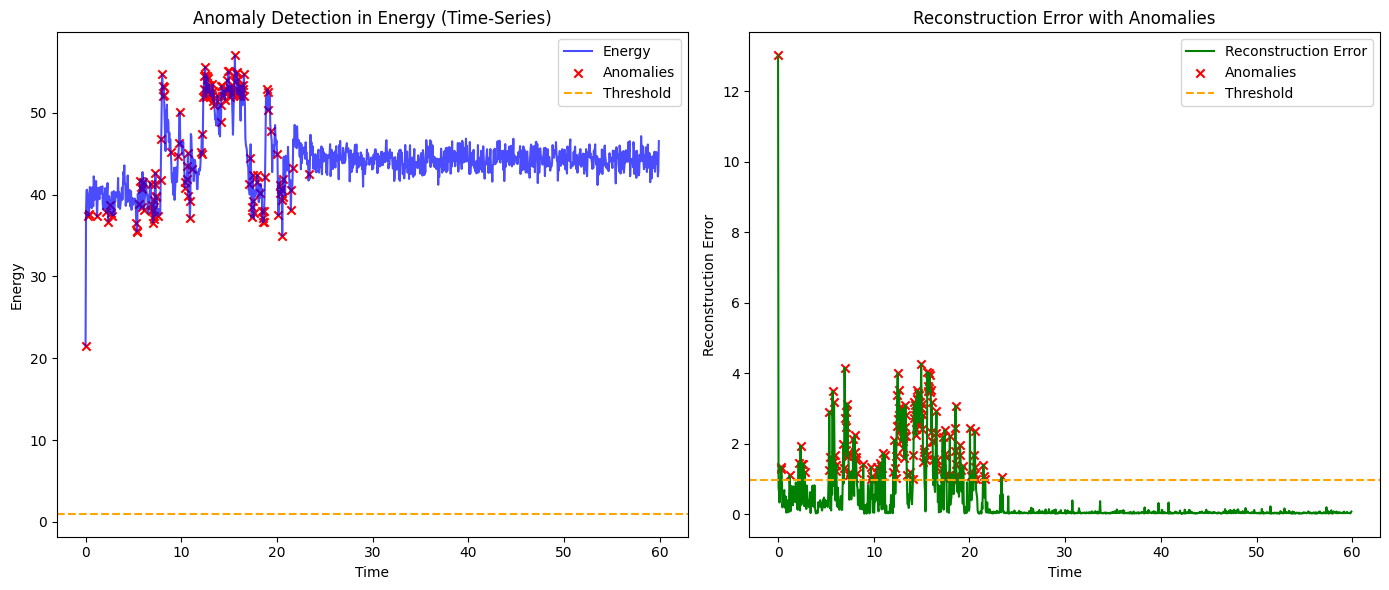

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    # Convert the dataset to a PyTorch tensor
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension
    reconstructed = model(data_tensor).squeeze(1).numpy()  # Remove sequence dimension for reconstruction

# Calculate reconstruction error
reconstruction_error = np.mean((data_scaled - reconstructed) ** 2, axis=1)

# Set a threshold (95th percentile for anomalies)
threshold = np.percentile(reconstruction_error, 87)

# Identify normal and anomalous points
anomalies = reconstruction_error > threshold
normal_points = reconstruction_error <= threshold

# Extract energy and timestamps (replace column indices if necessary)
energy = data[:, 5]  # Replace with the correct index for energy
timestamps = timestamps


# Split data into normal and anomalies based on the autoencoder
normal_energy = energy[normal_points]
anomaly_energy = energy[anomalies]
normal_times = timestamps[normal_points]
anomaly_times = timestamps[anomalies]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Energy over time with anomalies
axes[0].plot(timestamps, energy, label="Energy", alpha=0.7, color="blue")
axes[0].scatter(anomaly_times, anomaly_energy, color="red", marker="x", label="Anomalies")
axes[0].axhline(threshold, color="orange", linestyle="--", label="Threshold")
axes[0].set_title("Anomaly Detection in Energy (Time-Series)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Energy")
axes[0].legend()

# Plot 2: Reconstruction Error
axes[1].plot(timestamps, reconstruction_error, label="Reconstruction Error", color="green")
axes[1].scatter(anomaly_times, reconstruction_error[anomalies], color="red", marker="x", label="Anomalies")
axes[1].axhline(threshold, color="orange", linestyle="--", label="Threshold")
axes[1].set_title("Reconstruction Error with Anomalies")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Reconstruction Error")
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)

# Identifying anomalies
anomalies = data[dbscan_labels == -1]
print(f"Number of anomalies detected: {len(anomalies)}")


Number of anomalies detected: 437


In [ ]:
# Identifying anomalies using boolean indexing
anomalies_indices = dbscan_labels == -1  # Get boolean mask for anomalies
normal_indices = dbscan_labels != -1  # Get boolean mask for normal points

anomalies = data[anomalies_indices]
normal_points = data[normal_indices]
print(f"Number of anomalies detected: {len(anomalies)}")

Number of anomalies detected: 437


In [ ]:
2. Calculate distances to nearest core points
#   a. Identify core points
core_points_mask = np.zeros_like(dbscan_labels, dtype=bool)
core_points_mask[dbscan.core_sample_indices_] = True

#   b. Calculate distances to nearest core points for all points
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(data_scaled[core_points_mask])
distances, _ = neigh.kneighbors(data_scaled, return_distance=True)
distances = distances.ravel()  # Flatten the distances array

# 3. Set a threshold (e.g., 95th percentile of distances)
threshold = np.percentile(distances, 95)

# 4. Identify anomalies based on the threshold
anomalies_indices = (dbscan_labels == -1) | (distances > threshold)  # Outliers or far from core points
normal_indices = ~anomalies_indices

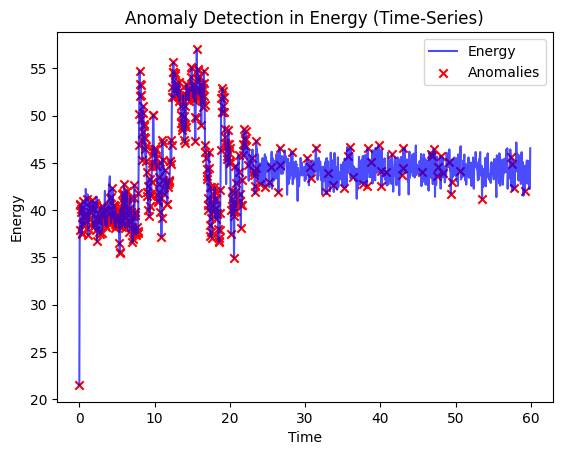

In [ ]:
energy = data[:, 5]  # Replace with the correct index for energy
timestamps = timestamps


# Split data into normal and anomalies based on the autoencoder
normal_energy = energy[normal_indices]
anomaly_energy = energy[anomalies_indices]
normal_times = timestamps[normal_indices]
anomaly_times = timestamps[anomalies_indices]

# Visualization


# Plot 1: Energy over time with anomalies
plt.plot(timestamps, energy, label="Energy", alpha=0.7, color="blue")
plt.scatter(anomaly_times, anomaly_energy, color="red", marker="x", label="Anomalies")
plt.title("Anomaly Detection in Energy (Time-Series)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()